In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
cf3  = np.genfromtxt('cf3.csv' , delimiter='|', filling_values=-1, names=True, dtype=None, encoding=None)
pgc_cf3 = cf3['PGC']
DM_cf3  = cf3['DM']
eDM_cf3 = cf3['eDM']
N_cf3   = cf3['N']  
C_cf3   = cf3['C']  
F_cf3   = cf3['F']
I_cf3   = cf3['I']
S_cf3   = cf3['S']
H_cf3   = cf3['H']
VVmod_cf3 = cf3['Vmod']
Ks_cf3 = cf3['Ks']

In [3]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        table
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [4]:
table = np.genfromtxt('DMs_EDD.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

pgc_edd = table['pgc']
logWimx   = table['logWimx']
logWimx_e = table['logWimx_e']
inc   = table['inc']
Vmod_edd   = table['Vmod']
Vls_edd   = table['Vls']

DM_edd  = table['DMr']
dDM_edd = table['dDMr']


DM_edd  = table['DMi']
dDM_edd = table['dDMi']


# DM_edd  = table['DMz'] 
# dDM_edd = table['dDMz']

# dDM_edd = table['dDMz']
# DM_edd  = (table['DMr']+table['DMi']+table['DMz'])/3.

# DM_edd  = table['DM_w1']
# dDM_edd = table['dDM_w1']


ggg = table['ggg']
rrr = table['rrr']
iii = table['iii']
zzz = table['zzz']
w11 = table['w1']
w22 = table['w2']


Sqlt = table['Sqlt']
Wqlt = table['Wqlt']

RS = table['RS']
P0 = table['P0']


I = iii-DM_edd


W1 = w11-DM_edd
print len(pgc_edd)

g_i = ggg-iii

i_w = iii-w11

10737


In [5]:
drop = np.genfromtxt('TF_drop.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_drop = drop['PGC']


faint = np.genfromtxt('TF_faint.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_faint = drop['PGC']

In [6]:
logD = (DM_edd-25)/5.
logH = np.log10(Vmod_edd) - logD  

keep = pgc_edd*0.

p = 0
for i, idd in enumerate(pgc_edd):
    
    if not idd in pgc_drop and not idd in pgc_faint:
        
        keep[i] = 1
    else:
        p+=1

        
print p

474


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [7]:
# indx, = np.where((logH<10) & (logH>0.5) & (Vmod_edd>0) & (iii>0) & (I<-17) & (zzz>0)  & (rrr>0)
#                  & (Sqlt>3) & (keep==1) & (logWimx>0) & (iii<100) & (DM_edd>0) & (RS>-1))

indx, = np.where((logH<2.5) & (logH>1.5) & (Vmod_edd>0) & (w11>0) & (Wqlt>3) & 
                 (keep==1) & (W1<-16.1) & (logWimx>0) & (i_w<-0.3)) #  & (logWimx<10.0) & (iii>0) & (I<-17)& (Sqlt>3))

Vmod = Vmod_edd[indx]
X0 = logWimx[indx]
X1  = logWimx_e[indx]
Ye = 0.2*dDM_edd[indx]
V  = Vls_edd[indx]
Y  = logH[indx]
lgD = logD[indx]
I = I[indx]
ID = pgc_edd[indx]
DM = DM_edd[indx]
INC = inc[indx]
mag_i = iii[indx]
mag_z = zzz[indx]
GI = g_i[indx]
W1 = W1[indx]
w1_mag = w11[indx]
P = X0/X1

P0 = P0[indx]

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


11.26 69.74842754164005
11.754999999999999 78.12185625558008
12.26 78.91259929690206
12.765 75.93711720242757
13.26 74.69617483159257
13.735 74.97979802480488
14.245000000000001 73.67225731787781
14.72 73.70297391033472
15.16 68.29533848530485
15.71 72.98712547619687
16.155 65.88772806686087
16.53 79.9824042292329


(11, 18)

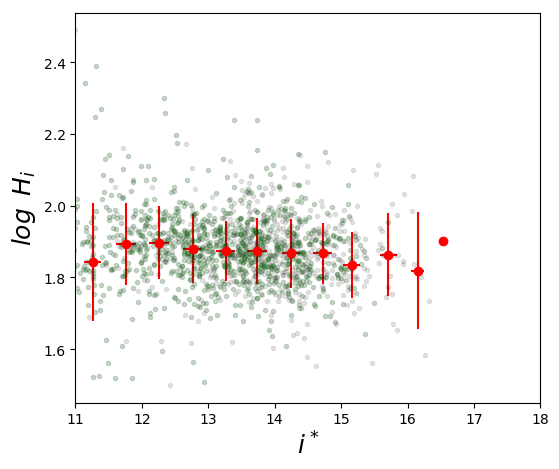

In [8]:
def hf(x,x0,a,c):
    
    y = a*x**2-2*a*x0*x+c
    
    try: 
        y[x<x0] = -a*x0**2+c
    except:
        if x<x0: y=0
    
    return y


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(mag_i,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)


for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(mag_i[i], Y[i], 'g.', alpha=0.1)  
        
        
        
X = mag_i 


for i in np.arange(11,18,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.set_xlabel(r'$i^*$', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_i$', fontsize=18) 

v = np.linspace(11,18,50)


# fit, cov = curve_fit(hf, X[X>12.], Y[X>12.], sigma=Ye[X>12.])
# ax.plot(v,hf(v, fit[0], fit[1], fit[2]), '--')


# set_axes(ax, fontsize=12)



# y = Y[(mag_i>12) & (mag_i<15)]
# ye = Ye[(mag_i>12) & (mag_i<15)]
# print 10**np.median(Y)
# print  10**(np.sum(y/ye)/np.sum(1./ye))
# med = np.median(Y)
# print "med0= ", med, 10**med

# print "Fit med:", 10**(hf(fit[0], fit[0], fit[1], fit[2]) )
# med = (hf(fit[0], fit[0], fit[1], fit[2]) )


# print "med: ", med, 10**med

ax.set_xlim(11,18)

-4.06 89.92601552105467
-3.68 73.38579103200965
-3.18 76.9140896407172
-2.74 72.0015744818419
-2.25 71.21435044206576
-1.73 73.22194813506363
-1.23 74.69051138597034
-0.74 75.93726764939872
-0.25 76.43551234227945
0.25 76.41067020167182
0.76 75.74966014801028
1.21 74.93282857526575
1.63 75.02111429652872
2.14 68.29392050698321
[1.43220751e-03 5.06795244e-03 1.88423252e+00]
1.8755872603598267 75.09089148896165


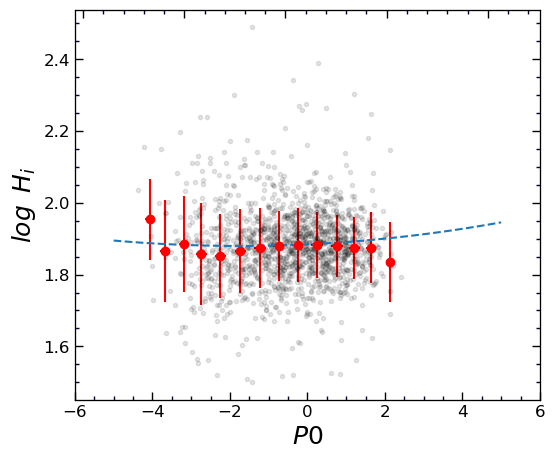

In [9]:
def hf(x,x0,a,c):
    
    y = a*x**2-2*a*x0*x+c
    
    try: 
        y[x<x0] = -a*x0**2+c
    except:
        if x<x0: y=0
    
    return y


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(P0,Y, 'k.', alpha=0.1)


for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(mag_i[i], Y[i], 'g.', alpha=0.1)  
        
        
        
X = P0 


for i in np.arange(-6,6,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.set_xlabel(r'$P0$', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_i$', fontsize=18) 

set_axes(ax, fontsize=12)


ax.set_xlim(-6,6)

v = np.linspace(-5, 5, 50)
c = np.polyfit(X, Y, 2, w=1./Ye)
ax.plot(v,c[0]*v**2+c[1]*v+c[2], '--')

# Y = Y - (c[0]*X**2+c[1]*X+c[2]) + med

print c
med = np.median(Y)
print med, 10**med


11.26 69.74842754164005
11.754999999999999 78.12185625558008
12.26 78.91259929690206
12.765 75.93711720242757
13.26 74.69617483159257
13.735 74.97979802480488
14.245000000000001 73.67225731787781
14.72 73.70297391033472
15.16 68.29533848530485
15.71 72.98712547619687
16.155 65.88772806686087
16.53 79.9824042292329


(11, 18)

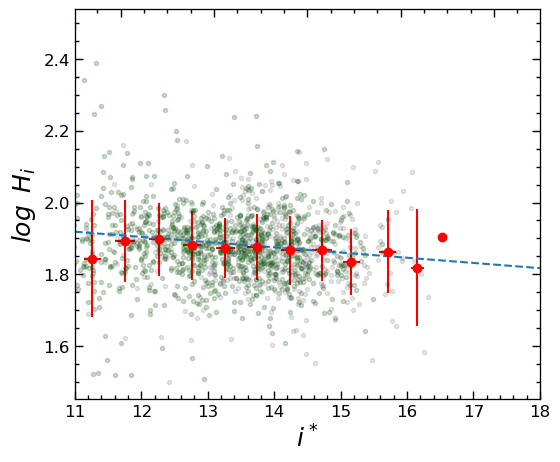

In [10]:
def hf(x,x0,a,c):
    
    y = a*x**2-2*a*x0*x+c
    
    try: 
        y[x<x0] = -a*x0**2+c
    except:
        if x<x0: y=0
    
    return y


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(mag_i,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)


for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(mag_i[i], Y[i], 'g.', alpha=0.1)  
        
        
        
X = mag_i 


for i in np.arange(11,18,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.set_xlabel(r'$i^*$', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_i$', fontsize=18) 

v = np.linspace(11,18,50)


set_axes(ax, fontsize=12)


c = np.polyfit(X[(X>12.)&(X<15)],Y[(X>12.)&(X<15)], 1, w=1./Ye[(X>12.)&(X<15)])
ax.plot(v,c[0]*v+c[1], '--')


ax.set_xlim(11,18)

11.22 75.2494004125788
11.76 74.1068628979078
12.29 78.33450168124648
12.79 79.52684299947397
13.24 75.20599648305381
13.77 74.08442856285362
14.25 75.14433519844714
14.74 73.80502268097955
15.2 73.98657018376153
15.75 70.38882874166333
16.185000000000002 74.13672798740647
16.68 72.69117291141319
17.17 63.2148050475821
[ 5.70958786e-04 -2.41583777e-02  2.10195361e+00]
1.8755872603598267 75.09089148896165


(10, 18)

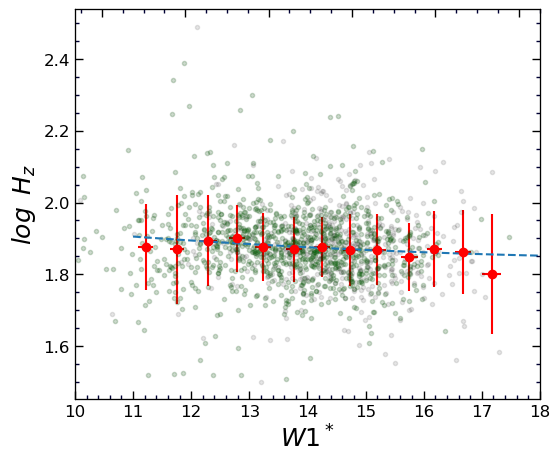

In [11]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(w1_mag,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)


for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(w1_mag[i], Y[i], 'g.', alpha=0.1)  
        
        
X = w1_mag 


for i in np.arange(11,18,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.set_xlabel(r'$W1^*$', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_z$', fontsize=18) 

v = np.linspace(11,18,50)

c = np.polyfit(X,Y, 2)#, w=1./Ye[(X>2.3)&(X<2.8)])
ax.plot(v,c[0]*v**2+c[1]*v+c[2], '--')


print c

set_axes(ax, fontsize=12)

print med, 10**med

ax.set_xlim(10,18)

49.0 67.95113686545723
52.0 74.70758656508156
57.0 72.82202277855058
62.0 71.11758270426502
68.0 73.65231446016469
72.0 75.2429275586399
77.0 77.27480736361805
82.0 77.57589959110906
88.0 78.26718652674022


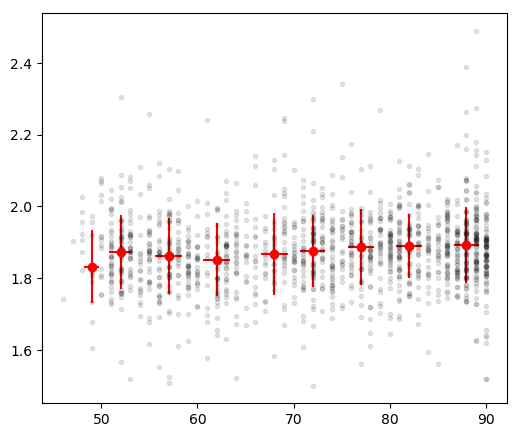

In [12]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(INC,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)



for i in np.arange(45,90,5):
    xp = []
    yp = []
    for ii in range(len(INC)):
        xi = INC[ii]
        if xi>=i and xi<i+5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)
        
        


-22.72 74.30958873630723
-22.155000000000005 76.82560628943341
-21.535 73.05100683448079
-20.799999999999997 75.04158488184129
-20.155 75.61359423144373
-19.5 75.90310672845064
-18.83 78.1793796710587
-18.120000000000005 73.19540604473717
-17.540000000000003 92.71513050644688
1.8755872603598267 75.09089148896165


(-25, -17)

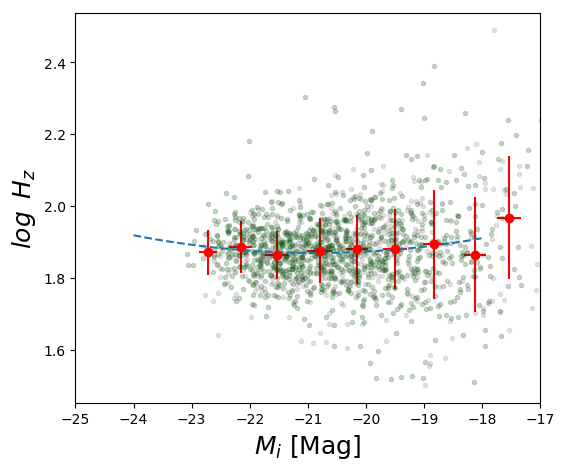

In [13]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(I,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)


for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(I[i], Y[i], 'g.', alpha=0.1)   
        
        
X = I 


for i in np.arange(-24,-17,0.7):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.7:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)
        
ax.set_xlabel(r'$M_i$'+' [Mag]', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_z$', fontsize=18) 


v = np.linspace(-24,-18,50)
c = np.polyfit(X[X>-23],Y[X>-23], 2)#, w=1./Ye[(X>2.3)&(X<2.8)])
ax.plot(v,c[0]*v**2+c[1]*v+c[2], '--')


print med, 10**med

ax.set_xlim(-25,-17)

C=  [50.4560044  -3.50811802  1.92293578]
Median =  1.8755872603598267 75.09089148896165
0.007 79.0244300665012
0.012 78.02029805517616
0.017 74.46799179298658
0.022 73.03716974252596
0.027 72.82202277855058
0.032 72.32368057359987
0.037 73.01824074863946
0.042 74.5868612161198
0.046 76.63954794383625
0.0515 79.92004980229386
0.0565 69.75444831734421
75.09089148896165


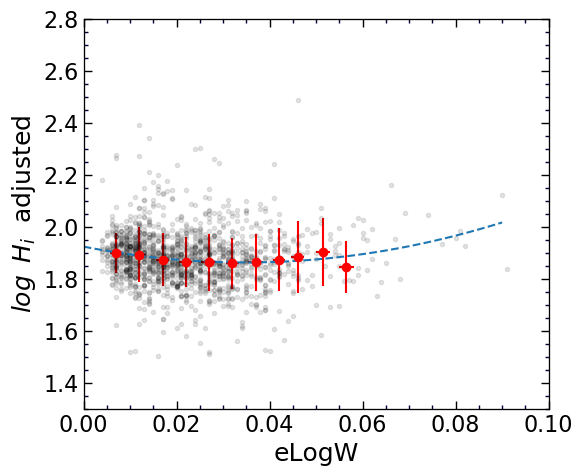

In [14]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.set_xlim(0,0.1)
ax.set_ylim(1.3,2.8)
v = np.linspace(0,0.09,50)

X = X1

xx = X
yy = Y

c = np.polyfit(X[X<0.1],Y[X<0.1], 2, w=1./Ye[X<0.1])


print 'C= ', c


print 'Median = ', med,  10**med

ax.plot(X, Y, 'k.', alpha=0.1)
ax.plot(v, c[0]*v**2+c[1]*v+c[2], '--')


XL = []
YL = []
YLe = []
for i in np.arange(0,0.08,0.005):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.005:# and ID[ii] in pgc_cf3:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>10:
        sqN = np.sqrt(len(xp))
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)  
        print np.median(xp), 10**np.median(yp)
        XL.append(np.median(xp))
        YL.append(np.median(yp))
        YLe.append(np.median(np.std(yp/sqN)))

ax.set_xlabel('eLogW', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{i}$'+'  adjusted', fontsize=18) 



set_axes(ax)

print 10**med

# Y = Y - (c[0]*X**2+c[1]*X+c[2]) + med  


2.26 77.948265997002
2.352 74.63241003472491
2.4505 75.3226590420057
2.549 73.19090958443837
2.648 74.62065000565197
2.726 79.52684299947397
[0.01317542 1.85039833]


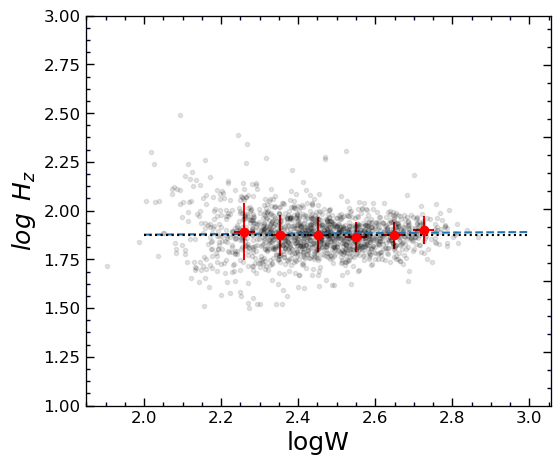

In [15]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = X0 

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(2.2,2.8,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.set_xlabel('logW', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_z$', fontsize=18) 

v = np.linspace(2,3,50)
# c = np.polyfit(XL,YL, 1, w=1./np.asarray(YLe))
c = np.polyfit(X[(X>2.2)&(X<2.8)],Y[(X>2.2)&(X<2.8)], 1, w=1./Ye[(X>2.2)&(X<2.8)])
ax.plot(v,c[0]*v+c[1], '--')


print c

set_axes(ax, fontsize=12)

# 
# Y = Y - (c[0]*X+c[1])+ med
# 

ax.set_ylim(1,3)

ax.plot([2.0, 3.0],[med, med], ':', color= 'k')

4661 76.7
5443 76.9
6519 78.0
7468 77.2
8408 76.6
9477 74.7
10432 74.6
11662 78.5
12416 78.4
13425 71.0
14944 73.5
15056 71.5
16856 66.5
79.61235541760462 73.64860346938426
[-3.07417791e-06  1.91327718e+00]
1.9009804731809714
75.09089148896165
77.4382958250439


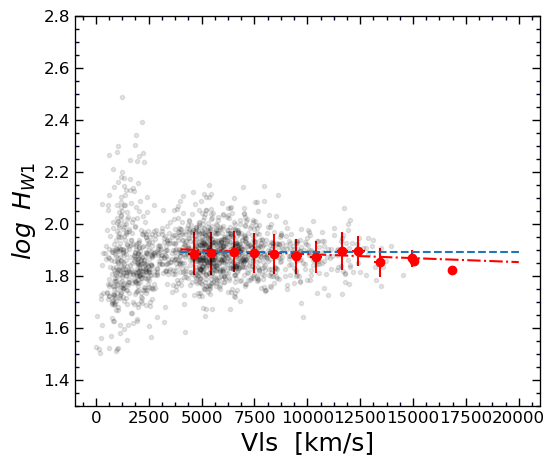

In [16]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = V

ax.plot(X, Y, 'k.', alpha=0.1)


for i in np.arange(4000,18000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:# and ID[ii] in pgc_cf3:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print "%d"%np.median(xp), "%.1f"%10**np.median(yp)

ax.set_xlabel('Vls  [km/s]', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{W1}$', fontsize=18) 

v = np.linspace(4000,20000,2000)
# c = np.polyfit(XL,YL, 1, w=1./np.asarray(YLe))
c = np.polyfit(X[X>4000],Y[X>4000], 1, w=1./Ye[X>4000])
ax.plot(v,c[0]*v+c[1], 'r-.')


ax.set_ylim(1.3,2.8)

set_axes(ax, fontsize=12)

print 10**(c[0]*4000.+c[1]), 10**(c[0]*15000.+c[1])
print c
print c[0]*4000.+c[1]

print 10**np.median(Y)
m = (np.sum(Y[X>4000]/Ye[X>4000])/np.sum(1./Ye[X>4000]))
H0 = 10**m
print  H0

ax.plot([4000,20000], [m,m], '--')

In [17]:
len(Y)

1500

-22.72 74.30958873630723
-22.155000000000005 76.82560628943341
-21.535 73.05100683448079
-20.799999999999997 75.04158488184129
-20.155 75.61359423144373
-19.5 75.90310672845064
-18.83 78.1793796710587
-18.120000000000005 73.19540604473717
-17.540000000000003 92.71513050644688
1.8669181618203108 73.60683801615019


(-25, -17)

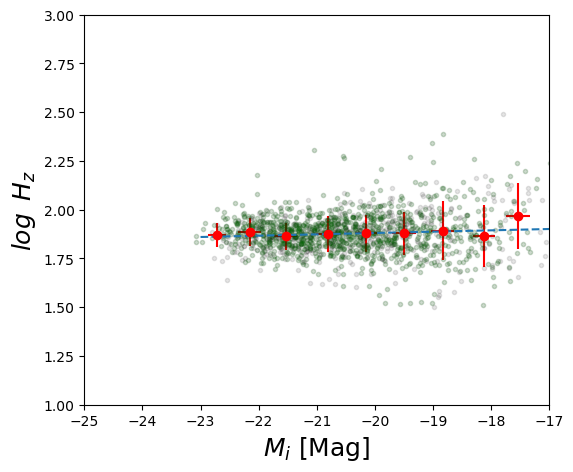

In [18]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(I,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)


for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(I[i], Y[i], 'g.', alpha=0.1)   
        
        
X = I 


for i in np.arange(-24,-17,0.7):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.7:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)
        
ax.set_xlabel(r'$M_i$'+' [Mag]', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_z$', fontsize=18) 


v = np.linspace(-23,-17,50)
c = np.polyfit(X[X>-23],Y[X>-23], 1)#, w=1./Ye[(X>2.3)&(X<2.8)])
ax.plot(v,c[0]*v+c[1], '--')


med = np.median(Y[(I>-22) & (I<-21)])
print med, 10**med

# Y = Y - (c[0]*X+c[1])+ med

ax.set_ylim(1,3)
ax.set_xlim(-25,-17)

11.26 69.74842754164005
11.754999999999999 78.12185625558008
12.26 78.91259929690206
12.765 75.93711720242757
13.26 74.69617483159257
13.735 74.97979802480488
14.245000000000001 73.67225731787781
14.72 73.70297391033472
15.16 68.29533848530485
15.71 72.98712547619687
16.155 65.88772806686087
16.53 79.9824042292329
[-0.0129549   2.05693654]
1.8755872603598267 75.09089148896165


(1, 3)

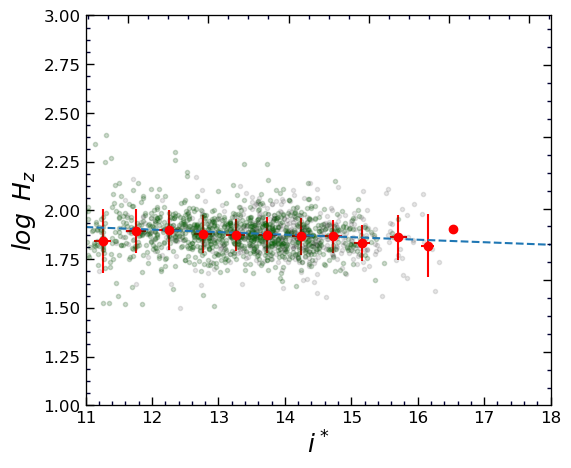

In [19]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(mag_i,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)


for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(mag_i[i], Y[i], 'g.', alpha=0.1)  
        
        
X = mag_i 


for i in np.arange(11,18,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.set_xlabel(r'$i^*$', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_z$', fontsize=18) 

v = np.linspace(11,18,50)

c = np.polyfit(X[(X>12.5)&(X<14.5)],Y[(X>12.5)&(X<14.5)], 1, w=1./Ye[(X>12.5)&(X<14.5)])
ax.plot(v,c[0]*v+c[1], '--')

print c

set_axes(ax, fontsize=12)

med0 = np.median(Y)

print med0, 10**med0

ax.set_xlim(11,18)
ax.set_ylim(1,3)

C=  [-1.70818938  1.91027922]
Median =  1.8908582345176062 77.77826202824812
0.007 79.3397608689597
0.014 76.09793823752075
0.024 72.9204207863112
0.034 72.6890779168246
0.043 75.31781537409536
0.054 79.15583755282098
0.0625 89.22836439467149


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa6626be6d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa6627dc450>)

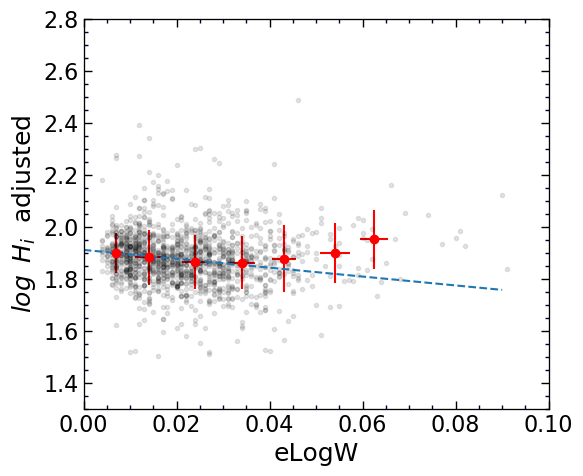

In [20]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.set_xlim(0,0.1)
ax.set_ylim(1.3,2.8)
v = np.linspace(0,0.09,50)

X = X1

xx = X
yy = Y

c = np.polyfit(X[X<0.04],Y[X<0.04], 1, w=1./Ye[X<0.04])


print 'C= ', c

med00 = np.sum(Y[X<0.02]/Ye[X<0.02])/np.sum(1./Ye[X<0.02])

print 'Median = ', med00,  10**med00




ax.plot(X, Y, 'k.', alpha=0.1)
ax.plot(v,c[0]*v+c[1], '--')


XL = []
YL = []
YLe = []
for i in np.arange(0,0.08,0.01):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.01:# and ID[ii] in pgc_cf3:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>10:
        sqN = np.sqrt(len(xp))
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)  
        print np.median(xp), 10**np.median(yp)
        XL.append(np.median(xp))
        YL.append(np.median(yp))
        YLe.append(np.median(np.std(yp/sqN)))

ax.set_xlabel('eLogW', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{i}$'+'  adjusted', fontsize=18) 



set_axes(ax)


Text(0.5,0,'$DM_{cf3}$')

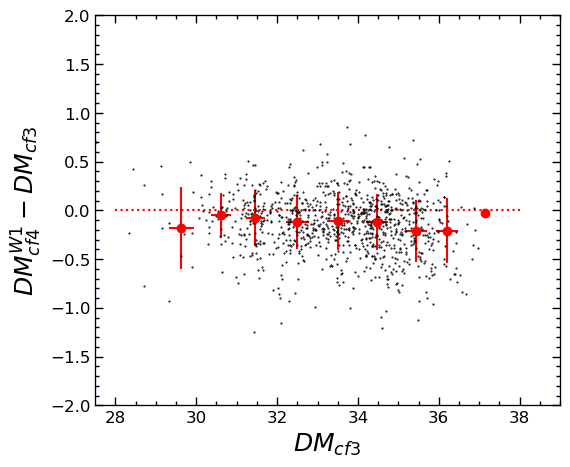

In [21]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


Y = 5.*(np.log10(Vmod) - Y)+25.

XX = []
YY = []
for i, id in enumerate(pgc_cf3):
    
    if id in ID:      
        ix, = np.where(ID==id)
        ax.errorbar(DM_cf3[i], Y[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
        XX.append(DM_cf3[i])
        YY.append(Y[ix][0]- DM_cf3[i])
            
for i in np.arange(29,38,1):
    xp = []
    yp = []
    for ii in range(len(XX)):
        xi = XX[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(YY[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)               
            

ax.set_ylabel(r'$DM^{W1}_{cf4}-DM_{cf3}$', fontsize=18)                                                 
set_axes(ax, [27.5,39],[-2,2], fontsize=12)
ax.plot([28,38],[0,0], 'r:')
ax.set_xlabel('$DM_{cf3}$', fontsize=18) 


1237.0 -0.11000000000000298
2657.0 -0.10999999999999943
5081.5 -0.13500000000000156
6839.0 -0.11999999999999744
9014.5 -0.18499999999999872
10673.0 -0.13999999999999346
12885.5 0.07000000000000028
14982.0 -0.14000000000000057
16856.0 -0.030000000000001137
-0.13949203187251003


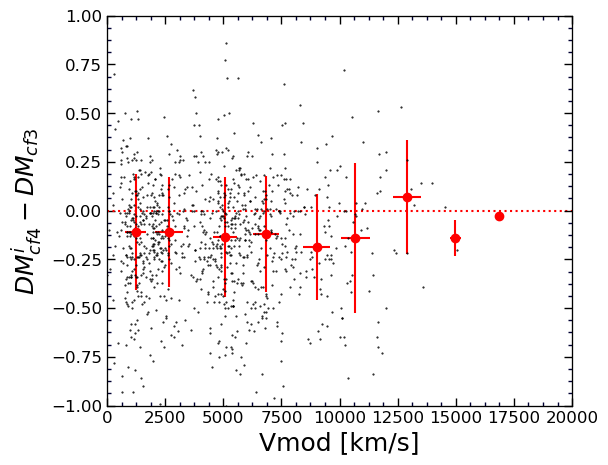

In [22]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)



XX = []
YY = []
for i, id in enumerate(pgc_cf3):
    
    if id in ID:
        ix, = np.where(ID==id)
        ax.errorbar(V[ix][0], Y[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
        XX.append(V[ix][0])
        YY.append(Y[ix][0]- DM_cf3[i])
            
for i in np.arange(0,20000,2000):
    xp = []
    yp = []
    for ii in range(len(XX)):
        xi = XX[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(YY[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)      
        print np.median(xp), np.median(yp)
            

ax.set_xlabel('Vmod [km/s]', fontsize=18) 
ax.set_ylabel(r'$DM^i_{cf4}-DM_{cf3}$', fontsize=18)                                                 
            
ax.plot([0,20000],[0,0], 'r:')
set_axes(ax, [0,20000],[-1,1], fontsize=12)

# set_axes(ax, [27.5,39],[-1,1], fontsize=12)
# ax.plot([28,38],[0,0], 'r:')
# ax.set_xlabel('$DM_{cf3}$', fontsize=18) 

print np.mean(YY)

1237.0 -0.11000000000000298
2657.0 -0.10999999999999943
5081.5 -0.13500000000000156
6839.0 -0.11999999999999744
9014.5 -0.18499999999999872
10673.0 -0.13999999999999346
12885.5 0.07000000000000028
14982.0 -0.14000000000000057
16856.0 -0.030000000000001137
-0.13949203187251003


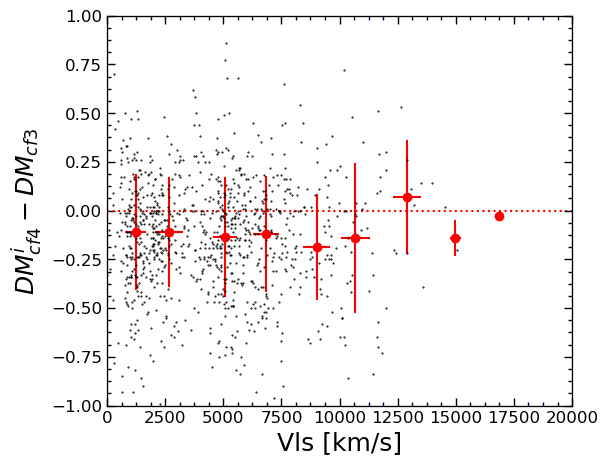

In [23]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)



XX = []
YY = []
for i, id in enumerate(pgc_cf3):
    
    if id in ID:
        ix, = np.where(ID==id)
        ax.errorbar(V[ix][0], Y[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
        XX.append(V[ix][0])
        YY.append(Y[ix][0]- DM_cf3[i])
            
for i in np.arange(0,20000,2000):
    xp = []
    yp = []
    for ii in range(len(XX)):
        xi = XX[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(YY[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)      
        print np.median(xp), np.median(yp)
            

ax.set_xlabel('Vls [km/s]', fontsize=18) 
ax.set_ylabel(r'$DM^i_{cf4}-DM_{cf3}$', fontsize=18)                                                 
            
ax.plot([0,20000],[0,0], 'r:')
set_axes(ax, [0,20000],[-1,1], fontsize=12)

# set_axes(ax, [27.5,39],[-1,1], fontsize=12)
# ax.plot([28,38],[0,0], 'r:')
# ax.set_xlabel('$DM_{cf3}$', fontsize=18) 

print np.mean(YY)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10


4562 73.3
5415 73.4
6559 73.5
7481 71.8
8486 71.3
9498 73.8
10508 68.8
11484 73.0
12419 68.1
13370 77.4
14389 69.2
15227 68.2
16612 75.1
17606 65.6
73.81362810824976 70.2542554881205
[-1.95126515e-06  1.87594161e+00]
1.868136552416611
2629


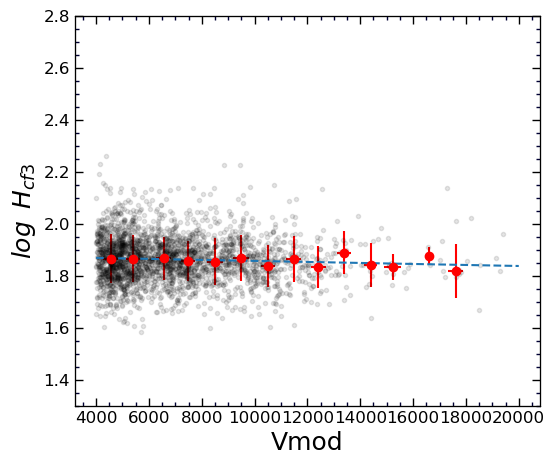

In [24]:
# pgc_edd = table['pgc']
# logWimx   = table['logWimx']
# logWimx_e = table['logWimx_e']
# inc   = table['inc']
# Vmod   = table['Vmod']

# pgc_cf3 = cf3['PGC']
# DM_cf3  = cf3['DM']
# eDM_cf3

Vmod_cf3 = []
logH_cf3 = []
eeDM_cf3 = []

for i, id in enumerate(pgc_cf3):
    
    if id in pgc_edd:      
        ix, = np.where(pgc_edd==id)
        logD_3 = (DM_cf3[i]-25)/5.
        logH_3 = np.log10(Vmod_edd[ix][0]) - logD_3
        Vmod_cf3.append(Vmod_edd[ix][0])
        logH_cf3.append(logH_3)
        eeDM_cf3.append(eDM_cf3[i])

Vmod_cf3 = np.asarray(Vmod_cf3)
logH_cf3 = np.asarray(logH_cf3)
eeDM_cf3  = np.asarray(eeDM_cf3)

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = Vmod_cf3[Vmod_cf3>4000]
Y = logH_cf3[Vmod_cf3>4000]
Ye = eeDM_cf3[Vmod_cf3>4000]

ax.plot(X, Y, 'k.', alpha=0.1)


for i in np.arange(4000,18000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print "%d"%np.median(xp), "%.1f"%10**np.median(yp)

ax.set_xlabel('Vmod', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{cf3}$', fontsize=18) 

v = np.linspace(4000,20000,2000)
c = np.polyfit(X[X>4000],Y[X>4000], 1, w=1/Ye[X>4000])
ax.plot(v,c[0]*v+c[1], '--')


ax.set_ylim(1.3,2.8)

set_axes(ax, fontsize=12)

print 10**(c[0]*4000.+c[1]), 10**(c[0]*15000.+c[1])
print c
print c[0]*4000.+c[1]

print len(Y)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


4574 73.5
5401 73.7
6541 73.0
7476 72.5
8493 73.3
9472 75.7
10497 74.7
11480 75.6
12426 76.1
13448 76.2
14432 75.4
15455 77.5
16458 76.0
17520 72.5
73.26122174854719 76.20013688855133
[1.55287223e-06 1.85866267e+00]
1.8648741569469809
8190


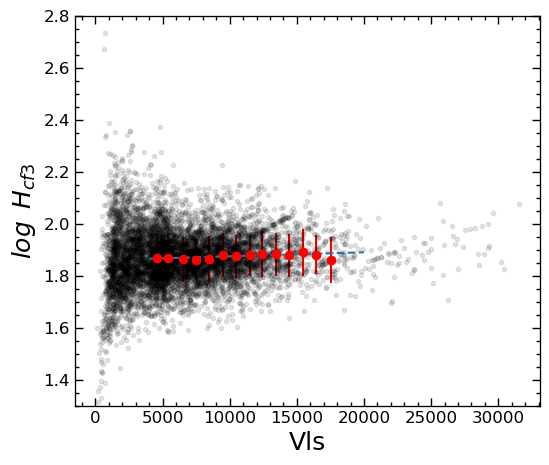

In [25]:
logD_3 = (DM_cf3-25)/5.
logH_3 = np.log10(VVmod_cf3) - logD_3

Vmod_cf3 = VVmod_cf3
logH_cf3 = logH_3
eeDM_cf3 = eDM_cf3

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = Vmod_cf3[(I_cf3=='I') | (H_cf3=='H') | (F_cf3=='F')]
Y = logH_cf3[(I_cf3=='I') | (H_cf3=='H')| (F_cf3=='F')]
Ye = eeDM_cf3[(I_cf3=='I') | (H_cf3=='H')| (F_cf3=='F')]

ax.plot(X, Y, 'k.', alpha=0.1)


for i in np.arange(4000,18000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000 :
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print "%d"%np.median(xp), "%.1f"%10**np.median(yp)

ax.set_xlabel('Vls', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{cf3}$', fontsize=18) 

v = np.linspace(4000,20000,2000)
c = np.polyfit(X[X>4000],Y[X>4000], 1, w=1/Ye[X>4000])
ax.plot(v,c[0]*v+c[1], '--')


ax.set_ylim(1.3,2.8)

set_axes(ax, fontsize=12)

print 10**(c[0]*4000.+c[1]), 10**(c[0]*15000.+c[1])
print c
print c[0]*4000.+c[1]

print len(Y)

5 90.7
6 nan
7 nan
8 72.5
9 71.7
10 72.7
11 nan
12 74.0


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


(5, 15)

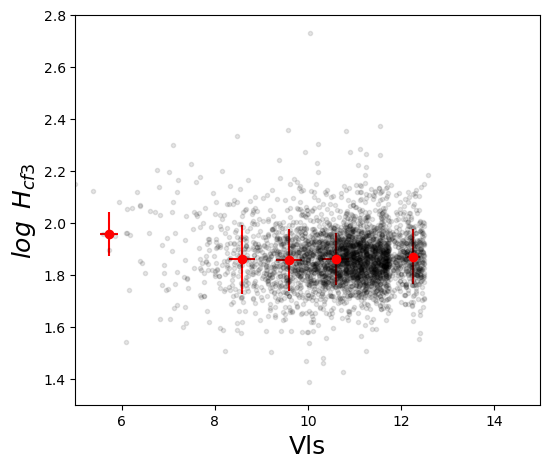

In [26]:
logD_3 = (DM_cf3-25)/5.
logH_3 = np.log10(VVmod_cf3) - logD_3

Vmod_cf3 = Ks_cf3
logH_cf3 = logH_3
eeDM_cf3 = eDM_cf3

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = Vmod_cf3[(I_cf3=='I') | (H_cf3=='H') ]
Y = logH_cf3[(I_cf3=='I') | (H_cf3=='H')]
Ye = eeDM_cf3[(I_cf3=='I') | (H_cf3=='H')]

ax.plot(X, Y, 'k.', alpha=0.1)


for i in np.arange(5,15,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 :
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print "%d"%np.median(xp), "%.1f"%10**np.median(yp)

ax.set_xlabel('Vls', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{cf3}$', fontsize=18) 

ax.set_ylim(1.3,2.8)
ax.set_xlim(5,15)


0.04999999999999982 1.0
0.22999999999999865 1.0
0.41000000000000014 1.0
0.6000000000000014 1.0
0.7999999999999989 1.0
0.9700000000000006 1.0
1.1500000000000004 1.0232929922807494


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa65778a4d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa65c1462d0>)

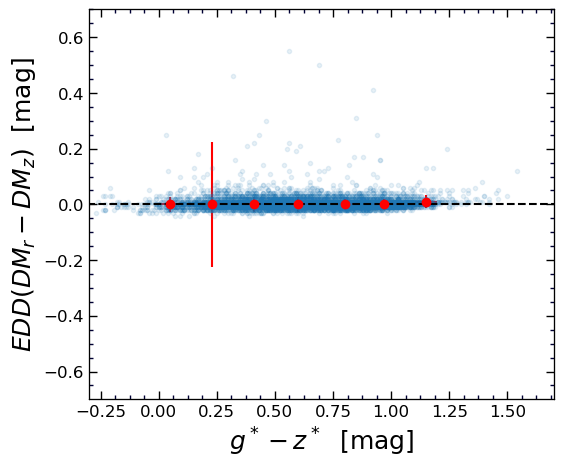

In [27]:
DMr  = table['DMr']
DMi  = table['DMi']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  ggg[indx]-zzz[indx] # logWimx[indx] #
Y = DMr[indx]-DMz[indx]

ax.plot(X, Y, '.', alpha=0.1)

# for i in np.arange(-1.8,2.8, 0.2):
for i in np.arange(-0.1,1.3, 0.20):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.plot([-3,3], [0,0], 'k--')
ax.set_xlim(-0.3,1.7)
ax.set_ylim(-0.7,0.7)

ax.set_xlabel(r'$g^*-z^* $'+'  [mag]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{r}-DM_z)$'+'  [mag]', fontsize=18) 
set_axes(ax, fontsize=12)

0.04999999999999982 0.9549925860214291
0.22999999999999865 0.9772372209558151
0.41000000000000014 1.0
0.6000000000000014 1.0
0.7999999999999989 1.0
0.9700000000000006 1.0232929922807494
1.1500000000000004 1.023292992280766


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa6568c7690>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa656dbd550>)

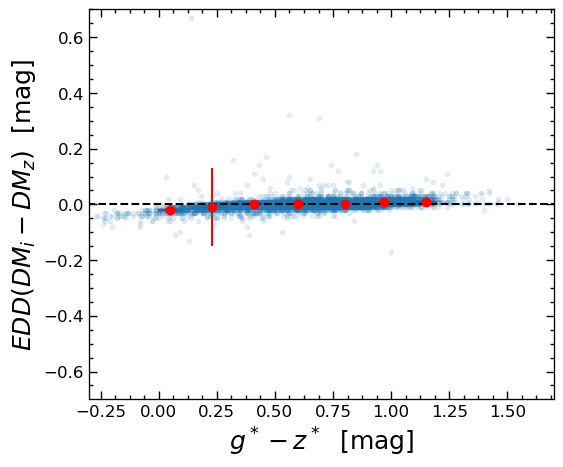

In [28]:
DMr  = table['DMr']
DMi  = table['DMi']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  ggg[indx]-zzz[indx] # logWimx[indx] #
Y = DMi[indx]-DMz[indx]

ax.plot(X, Y, '.', alpha=0.1)

# for i in np.arange(-1.8,2.8, 0.2):
for i in np.arange(-0.1,1.3, 0.20):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.plot([-3,3], [0,0], 'k--')
ax.set_xlim(-0.3,1.7)
ax.set_ylim(-0.7,0.7)

ax.set_xlabel(r'$g^*-z^* $'+'  [mag]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{i}-DM_z)$'+'  [mag]', fontsize=18) 
set_axes(ax, fontsize=12)

-0.030000000000001137 0.5499999999999972
0.07000000000000028 0.1850000000000005
0.15500000000000025 0.134999999999998
0.2599999999999998 0.09000000000000341
0.35999999999999943 0.03999999999999915
0.4599999999999991 0.0
0.5500000000000007 -0.020000000000003126
0.6499999999999986 -0.029999999999997584
0.75 -0.020000000000003126
0.8300000000000001 -0.01999999999999602
0.9299999999999997 -0.10500000000000043
1.0299999999999994 -0.0799999999999983
1.1400000000000006 0.019999999999999574
1.2199999999999989 -0.46999999999999886


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa65c2f3510>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa656756850>)

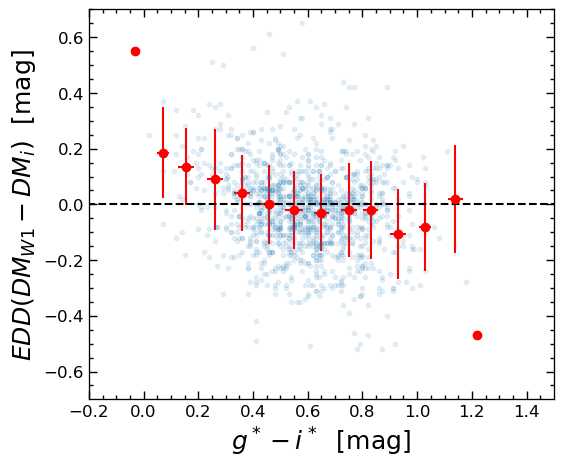

In [29]:
DMr  = table['DMr']
DMi  = table['DMi']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) &
                 (Wqlt>3) & (w11>0) &(logWimx<2.6) &(logWimx>2.2))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  ggg[indx]-iii[indx] # logWimx[indx] #
Y = DM_w1[indx]-DMi[indx]

ax.plot(X, Y, '.', alpha=0.1)

# for i in np.arange(-1.8,2.8, 0.2):
for i in np.arange(-0.2,1.5, 0.10):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.10:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), np.median(yp)

ax.plot([-3,3], [0,0], 'k--')
ax.set_xlim(-0.2,1.5)
ax.set_ylim(-0.7,0.7)

ax.set_xlabel(r'$g^*-i^* $'+'  [mag]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 
set_axes(ax, fontsize=12)

In [30]:
np.median(DMi[indx]-DMz[indx])

0.0

[-3.57840743e-06  2.52530971e-02]
0.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa656923e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa656e74450>)

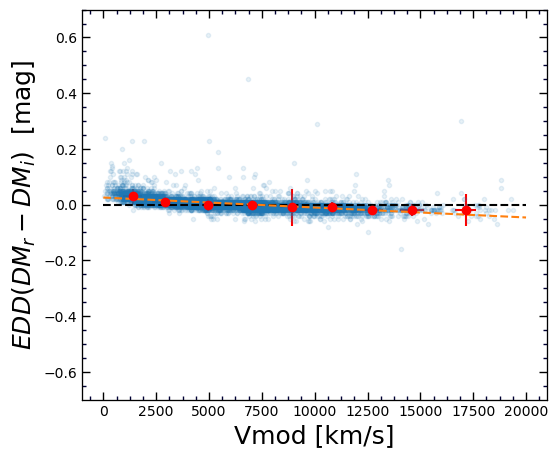

In [31]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & 
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  Vmod[indx] #
Y = (DMr[indx])-DMi[indx]
Ye = np.sqrt(dDMr**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(0,18000, 2000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
# ax.set_xlim(0,1.5)


v = np.linspace(0,20000,2000)
c = np.polyfit(X,Y, 1)
ax.plot(v,c[0]*v+c[1], '--')
ax.set_ylim(-0.7,0.7)
print c

ax.set_xlabel('Vmod [km/s]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{r}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)

set_axes(ax, fontsize=10)

[ 6.04299392e-07 -1.76495337e-03]
0.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa65ee5fe50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa656646890>)

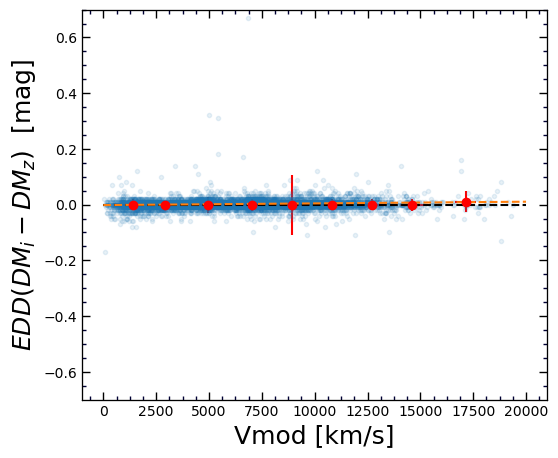

In [32]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & 
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  Vmod[indx] #
Y = (DMi[indx])-DMz[indx]
Ye = np.sqrt(dDMi**2+dDMz**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(0,18000, 2000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
# ax.set_xlim(0,1.5)


v = np.linspace(0,20000,2000)
c = np.polyfit(X,Y, 1)
ax.plot(v,c[0]*v+c[1], '--')
ax.set_ylim(-0.7,0.7)
print c

ax.set_xlabel('Vmod [km/s]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{i}-DM_z)$'+'  [mag]', fontsize=18) 

print np.median(Y)

set_axes(ax, fontsize=10)

-0.010000000000005116
-0.002309952465669859


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa65f0c1890>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa655d9c790>)

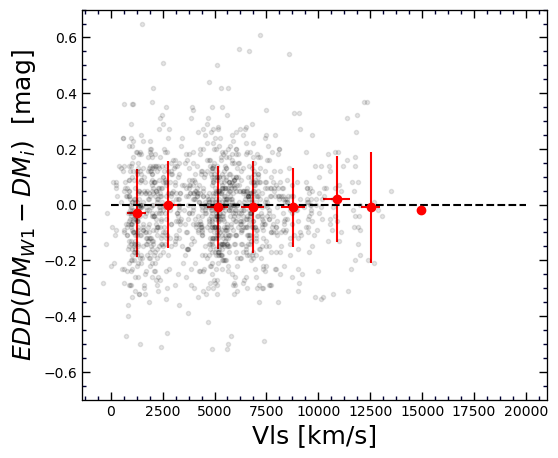

In [33]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
Vls   = table['Vls']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0) & (logWimx<2.6) & (logWimx>2.2) )


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  Vls[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(0,18000, 2000):
    xp = []
    yp = []
    ype  = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(Y[ii])
            ype.append(Ye[ii])
    if len(xp)>0:
        yp = np.asarray(yp)
        ype = np.asarray(ype)
        yy = np.median(yp)  #    np.sum(yp/ype)/np.sum(1./ype) # 
        ax.errorbar(np.median(xp), yy, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
# ax.set_xlim(0,1.5)


# v = np.linspace(0,20000,2000)
# c = np.polyfit(X,Y, 1)
# ax.plot(v,c[0]*v+c[1], '--')
ax.set_ylim(-0.7,0.7)

# c = np.polyfit(X,Y, 0, w=1./Ye)
# ax.plot(v, v*0+c[0], '--')


ax.set_xlabel('Vls [km/s]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print  np.sum(Y/Ye)/np.sum(1./Ye)

set_axes(ax, fontsize=10)

In [34]:
indx, = np.where((zzz>0) & (Sqlt>3) & (Wqlt>3) & (Vmod<20000))
Y = DM_w1[indx]-DMz[indx]
Ye = np.sqrt(dDM_w1[indx]**2+dDMz[indx]**2)
print np.sum(Y/Ye)/np.sum(1./Ye)
np.median(Y), np.mean(Y), np.std(Y)

0.013287028048792946


(0.0, 0.020617949975478115, 0.6550707711722853)

0.0
[ 0.19941896 -0.67633581  0.46835723]


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa656039c10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa655dead90>)

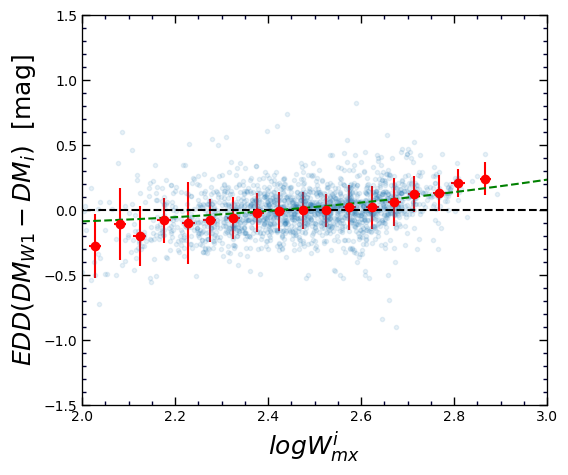

In [35]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']
dDMz = table['P0']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = logWimx[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,0.05):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.05:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
ax.set_xlim(2,3)


v = np.linspace(2, 3,20)
c = np.polyfit(X[(X>2.0)&(X<2.9)],Y[(X>2.0)&(X<2.9)], 3, w=1./Ye[(X>2.0)&(X<2.9)])
# ax.plot(v,c[0]*v**3+c[1]*v**2+c[2]*v+c[3], 'r--')

c = np.polyfit(X, Y, 2, w=1./Ye)
ax.plot(v,c[0]*v**2+c[1]*v+c[2], 'g--')



ax.set_ylim(-1.5,1.5)

ax.set_xlabel(r'$logW^i_{mx}$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print c
set_axes(ax, fontsize=10)

0.0
0.012838675254402576


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa6566a6990>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa655c3fdd0>)

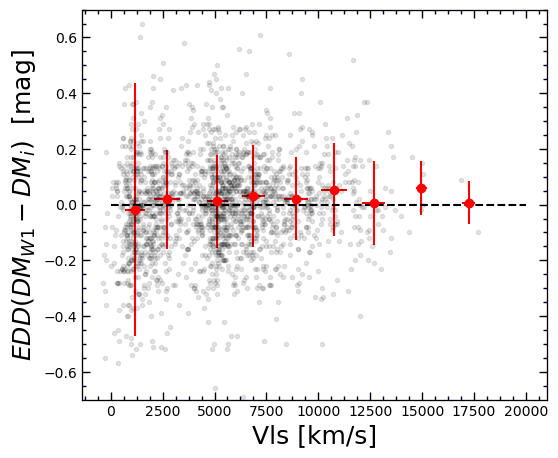

In [36]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  Vls[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(0,18000, 2000):
    xp = []
    yp = []
    ype  = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(Y[ii])
            ype.append(Ye[ii])
    if len(xp)>0:
        yp = np.asarray(yp)
        ype = np.asarray(ype)
        yy =  np.sum(yp/ype)/np.sum(1./ype) # np.median(yp)  #
        ax.errorbar(np.median(xp), yy, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
# ax.set_xlim(0,1.5)


# v = np.linspace(0,20000,2000)
# c = np.polyfit(X,Y, 1)
# ax.plot(v,c[0]*v+c[1], '--')
ax.set_ylim(-0.7,0.7)

# c = np.polyfit(X,Y, 0, w=1./Ye)
# ax.plot(v, v*0+c[0], '--')


ax.set_xlabel('Vls [km/s]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print  np.sum(Y/Ye)/np.sum(1./Ye)

set_axes(ax, fontsize=10)

In [37]:
np.median(Y)

0.0

0.0
[-4.98318829e-05  4.65385478e-05  2.99787911e-02]


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa65634bc50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa6563bee90>)

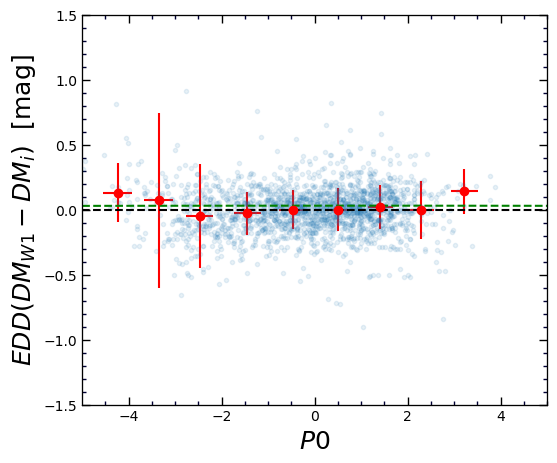

In [38]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']
P0 = table['P0']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = P0[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(-5,5,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([-5,5], [0,0], 'k--')
ax.set_xlim(-5,5)


v = np.linspace(-5,5,20)
c = np.polyfit(X, Y, 2, w=1./Ye)
ax.plot(v,c[0]*v**2+c[1]*v+c[2], 'g--')



ax.set_ylim(-1.5,1.5)

ax.set_xlabel(r'$P0$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print c
set_axes(ax, fontsize=10)

[ 0.01333541 -0.41848223]
0.0


(-1.5, 1.5)

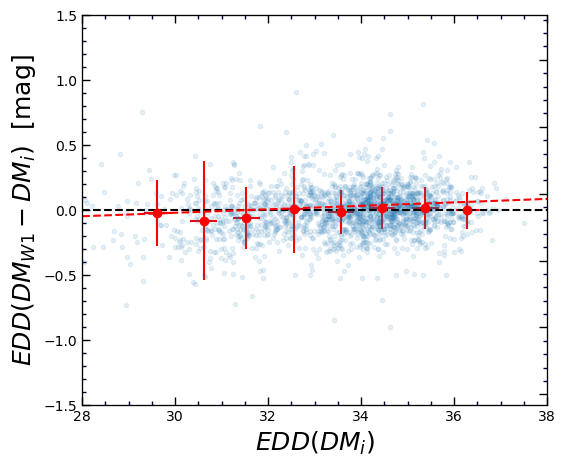

In [39]:
DMr  = table['DMr']
DMz  = table['DMz']
DMi  = table['DMi']

DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = DMi[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(29,37,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([28,38], [0,0], 'k--')
ax.set_xlim(28,38)


v = np.linspace(28,38,20)
m = np.polyfit(X, Y, 1, w=1./Ye)
ax.plot(v,m[0]*v+m[1], 'r--')
# ax.set_ylim(-0.7,0.7)

print m
ax.set_xlabel(r'$EDD(DM_{i})$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
set_axes(ax, fontsize=10)
ax.set_ylim(-1.5,1.5)

[ 0.00453879 -0.28024919  4.29797073]
-0.010000000000005116


(-1.5, 1.5)

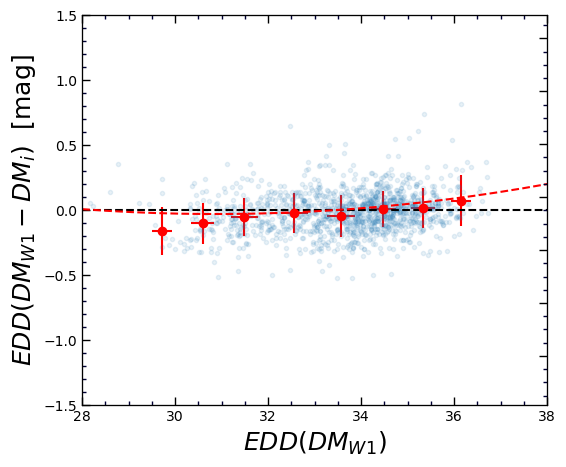

In [40]:
DMr  = table['DMr']
DMz  = table['DMz']
DMi  = table['DMi']

DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0)&(logWimx<2.6) &(logWimx>2.2))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = DM_w1[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(29,37,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([28,38], [0,0], 'k--')
ax.set_xlim(28,38)


v = np.linspace(28,38,20)
m = np.polyfit(X, Y, 2, w=1./Ye)
ax.plot(v,m[0]*v**2+m[1]*v+m[2], 'r--')
# ax.set_ylim(-0.7,0.7)

print m
ax.set_xlabel(r'$EDD(DM_{W1})$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
set_axes(ax, fontsize=10)
ax.set_ylim(-1.5,1.5)

[-0.26640601 -0.10389949]
0.0


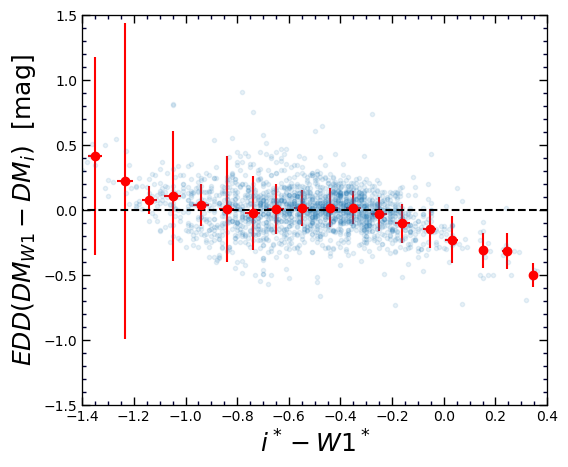

In [41]:
DMr  = table['DMr']
DMz  = table['DMz']
DMi  = table['DMi']

DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0) )

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = iii[indx]-w11[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(-1.4,0.4,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([28,38], [0,0], 'k--')
ax.set_xlim(-1.4,0.4)
ax.set_ylim(-1.5,1.5)

v = np.linspace(28,38,20)
m = np.polyfit(X, Y, 1, w=1./Ye)
ax.plot(v,m[0]*v+m[1], 'r--')
# ax.set_ylim(-0.7,0.7)

print m
ax.set_xlabel(r'$i^*-W1^*$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
set_axes(ax, fontsize=10)

ax.plot([-2,2], [0,0], 'k--')

[-0.00975308  0.33495571]
0.0
[-0.00975308  0.33495571]


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa655504990>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa655b95ed0>)

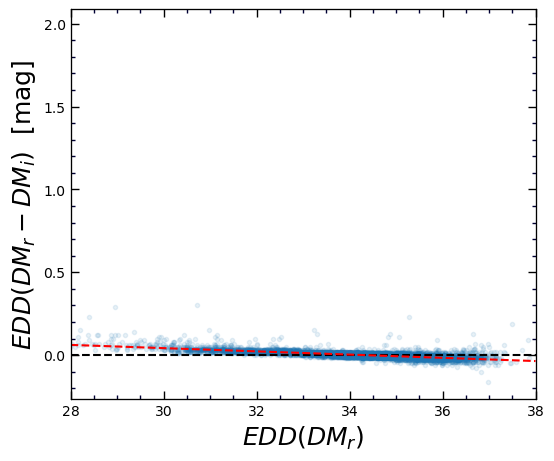

In [42]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & #(Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = DMr[indx] #
Y = (DMr[indx])-DMi[indx]
Ye = np.sqrt(dDMr**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([28,38], [0,0], 'k--')
ax.set_xlim(28,38)


v = np.linspace(28,38,20)
m = np.polyfit(X, Y, 1, w=1/Ye)
ax.plot(v,m[0]*v+m[1], 'r--')
# ax.set_ylim(-0.7,0.7)

print m
ax.set_xlabel(r'$EDD(DM_{r})$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{r}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print m
set_axes(ax, fontsize=10)

[-0.00107722  0.03592679]
0.0
[-0.00107722  0.03592679]


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa655951190>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa655388350>)

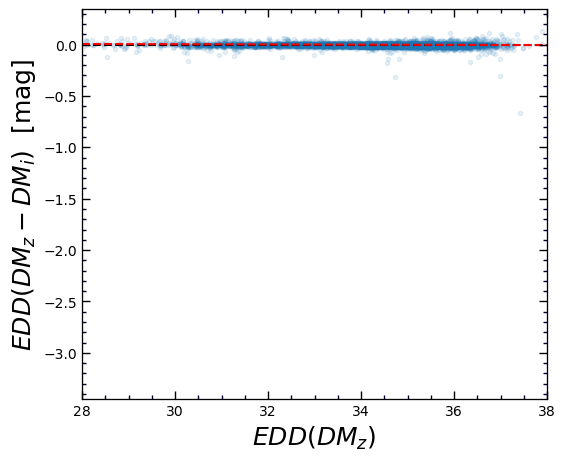

In [43]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & #(Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = DMz[indx] #
Y = (DMz[indx])-DMi[indx]
Ye = np.sqrt(dDMz**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([28,38], [0,0], 'k--')
ax.set_xlim(28,38)


v = np.linspace(28,38,20)
m = np.polyfit(X, Y, 1, w=1/Ye)
ax.plot(v,m[0]*v+m[1], 'r--')
# ax.set_ylim(-0.7,0.7)

print m
ax.set_xlabel(r'$EDD(DM_{z})$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{z}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print m
set_axes(ax, fontsize=10)

[ 0.11916336 -0.60456235  0.7622705 ]
0.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa655fc7810>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa6562aa5d0>)

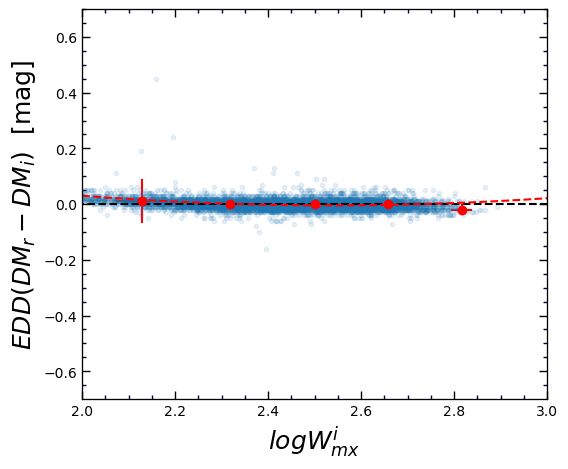

In [44]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & #(Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = logWimx[indx] #
Y = (DMr[indx])-DMi[indx]
Ye = np.sqrt(dDMr**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
ax.set_xlim(2,3)


v = np.linspace(2, 3,20)
c = np.polyfit(X,Y, 2)
ax.plot(v,c[0]*v**2+c[1]*v+c[2], 'r--')
ax.set_ylim(-0.7,0.7)
print c

ax.set_xlabel(r'$logW^i_{mx}$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{r}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)

set_axes(ax, fontsize=10)

[-0.01574699  0.07384809 -0.08374918]
0.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa65530e610>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa65c11f690>)

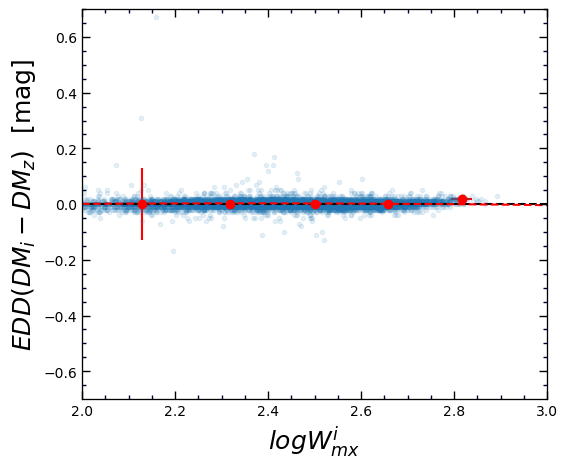

In [45]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & #(Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = logWimx[indx] #
Y = (DMi[indx])-DMz[indx]
Ye = np.sqrt(dDMi**2+dDMz**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
ax.set_xlim(2,3)


v = np.linspace(2, 3,20)
c = np.polyfit(X,Y, 2)
ax.plot(v,c[0]*v**2+c[1]*v+c[2], 'r--')
ax.set_ylim(-0.7,0.7)
print c

ax.set_xlabel(r'$logW^i_{mx}$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{i}-DM_z)$'+'  [mag]', fontsize=18) 

print np.median(Y)

set_axes(ax, fontsize=10)